# Neural Networks Implementation
It consists of five parts; 1. Implement Logistic Regression, 2. Easy Tasks, 3. Implement and Test a Shallow Neural Network, 4. Challenging Task, 5. Deep Learning Enhancements.

In [1]:
# Package imports
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Display plots inline and change default figure size
%matplotlib inline

## Part 1: Implement Logistic Regression

Logistic Regression is to find the linear dividing line between two classes, e.g. 0 and 1. Thus, the goal of logistic regression is to find suitable values for `w` and `b` to predict output values as close to the actual values as possible in the straigh line of `z(X) = w . X + b` during training.

In this implementation of logistic regression based on lecture 2, I apply *Sigmoid* function as an activation function to convert straight line equation into 0 or 1 values for classifier in the function `sigmoid`. The `sigmoid` function returns outputs between 0 and 1 and is written as `f(z)`.

        f(z) = 1 / (1 + e^-z)  where the linear regression formula, z_(w,b)(x) = w . x + b

The estimated output `y_hat` is then calculated by the activation function to find the probability that the actual output `y` is 1, given a set of input `X`: `y_hat = P(y=1|X;w,b)`

        y_hat = a_(w,b)(X) = f(w . X + b)

In [2]:
# Sigmoid Function as Activation Function for Logistic Regression
# Numpy document (cheat sheet): https://numpy.org/doc/stable/user/quickstart.html
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

To find values for `w` and `b`, a loss function `L()` and a cost function `J()` need to be defined. In here, I apply *Gradient Descent* optimisation algorithm to search for weights `w` and bias `b` that **minimise** the cost for a given training set since `y_hat` tends to the correct value when `J()` tends to 0.

        min_(w,b) J(w,b)

Thus, we can get a *Log Loss* for a single case of `Xi` and `yi`. As we are dealing with a single case each iteration, it is called Stochastic Gradient Descent which is implemented in `stochastic_cost_function` and the cost function is written as follows.

        J(w,b) = - (yi * log(yi_hat) + (1 - yi) * log(1 - yi_hat))

In practice, I added a small number `epsilon` to `log()` function when the log input is zero to prevent runtime errors but also the epsilon does not make any significant effect on the cost function value as mentioned during the classes.

In [3]:
def stochastic_cost_function(y, y_hat):
    if y_hat == 0 or y_hat ==1:
        epsilon = 1 * math.exp(-6)  # idea from discussion board
        return -1 * (y * math.log(y_hat + epsilon) + (1 - y) * math.log(1 - y_hat + epsilon))
    else:
        return -1 * (y * math.log(y_hat) + (1 - y) * math.log(1 - y_hat))

Also, the partial derivatives for Stochastic Gradient Descent are as follows.
    
        delta_wj = (yi_hat - yi) * xji
        delta_b = yi_hat - yi

So, to find the minimum cost function we take incremental steps 'downhill' with step size controlled by learning rate `alpha` to calculate the cost function until there is little, i.e. less than the threshold, or no change between the current value and the previous value. In other words, when the difference between the current value and the previous value of the cost function is less than the threshold, break out of the iteration loop.

### Brief Description of Algorithm (Stochastic Gradient Descent)
***accuracy***
* Calculate the proportion of the correct prediction

**MyLogisticRegression.*fit***
* Set values for `alpha`, `max_iterations`, `threshold`
    * `max_iterations` to 10 times of the size of the input `X`
* Initialise `w`, `b` to a set of small random numbers (`w` is same size as `Xi`)
* Loop max number of iterations:
    * Select a single example `{Xi, yi}` from training set at random
    * FORWARD PROPAGATION STAGE
        * Calculate `y_hat` with `sigmoid` function from `Xi`, `w`, `b`
        * Calculate `J_curr` with `stochastic_cost_function` from `y` and `y_hat`
        * Compare `J_curr` with `J_prev`: break from loop if convergence is reached as described above
    * GRADIENT DESCENT STAGE
        * Loop over the *j* elements of `w`: Calculate `delta_b`, Calculate `delta_wj` as shown above
        * Loop again over the *j* elements of `w`: `wj -= alpha * delta_wj`, `b -= alpha * delta_b`

**MyLogisticRegression.*predict***
* Apply weights `w` and bias `b` to input `X` and get `y_hat` by `sigmoid` function
* Make a prediction by checking whether the probability is greater than 0.5 that the actual output `y` is 1 given a set of input `X`.

**MyLogisticRegression.*find_learning_rate***
* Loop for each candidate `alpha` value:
    * Fit the model
    * Predict the output
* Compare the accuracies on the list of `alpha`s to find the highest accuracy
* If the highest accuracy occurs in more than one element, get the smaller iteration numbers taken

In [4]:
def accuracy(y, y_predict):
    return (1.0 - np.sum(y!=y_predict) / len(y)) * 100

In [5]:
class MyLogisticRegression:
    def fit(self, X, y, alpha=0.01, return_iteration=False, return_cost=False):
        # initialisation
        max_iterations = 10 * len(X)
        threshold = 1 * math.exp(-8)
        # set random w and b
        X_shape = X.shape
        w = np.random.normal(0, 0.01, size=X_shape[1])
        b = np.random.normal(0, 0.01, size=1)[0]
        # Loop for max iterations
        iteration = 0
        J_curr = None
        J_iterations = []
        while iteration < max_iterations:
            # single example from training set selected at random
            X_copy = X.copy()
            y_copy = y.copy()
            # select a random row of X and y
            random_indice = np.random.choice(X_copy.shape[0], size=1, replace=False)
            Xi = X_copy[random_indice, :][0]
            yi = y_copy[random_indice][0]
            # Forward propagation stage
            yi_hat = sigmoid(Xi.dot(w) + b)
            if iteration > 1:
                J_prev = J_curr
            J_curr = stochastic_cost_function(yi, yi_hat)
            J_iterations.append(J_curr)
            # check convergence
            if iteration > 1 and abs(J_curr - J_prev) < threshold:
                break # finish entire process ...
            # Gradient Descent stage
            # loop over the j elements of w: delta_wj, delta_b
            delta_b = yi_hat - yi
            delta_w = []
            for xji in Xi.T:  # column iteration
                delta_wj = delta_b * xji
                delta_w.append(delta_wj)
            # loop again over the j elements of w: wj -= alpha * delta_wj, b -+ alpha * delta_b
            w -= alpha * np.array(delta_w) # numpy with list to multiply by scalar
            b -= alpha * delta_b
            iteration += 1
        if return_iteration and return_cost:
            return w, b, iteration, J_iterations
        elif return_iteration:
            return w, b, iteration
        elif return_cost:
            return w, b, J_iterations
        else:
            return w, b

    def predict(self, X, w, b):
        # predict y, y_hat, f(w.x+b) = 1 / (1+e^-(w.x+b))
        y_hat = sigmoid(X.dot(w) + b)
        y_predict = [(lambda i: 0 if i < 0.5 else 1)(i) for i in y_hat] # 0 if y_hat < 0.5 else 1
        return y_predict

    def find_learning_rate(self, X, y, X_validation, y_validation):
        alphas = [0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1]
        accuracy_for_alphas = []
        iteration_for_alphas = []
        for alpha in alphas:
            w, b, iteration = self.fit(X, y, alpha, return_iteration=True)
            y_predict = self.predict(X_validation, w, b)
            prediction_accuracy = accuracy(y_validation, y_predict)
            accuracy_for_alphas.append(prediction_accuracy)
            iteration_for_alphas.append(iteration)
        max_accuracy_indices = np.argwhere(accuracy_for_alphas == np.amax(accuracy_for_alphas)) # find index of max
        max_accuracy_indices = np.reshape(max_accuracy_indices, len(max_accuracy_indices))  # double list to flat list
        max_accuracy_indices = max_accuracy_indices.tolist()  # numpy to list
        iteration_for_alphas = np.array(iteration_for_alphas)  # get elements by index list
        min_iteration_indices = np.argwhere(iteration_for_alphas == np.amin(list(np.array(iteration_for_alphas[max_accuracy_indices]))))  # get elements by index list
        return alphas[min_iteration_indices[0][0]]

## Part 2: Easy Tasks

Firstly, we will test Logistic Regression code (Part 1) with the dataset "blobs250.csv". 

The *blobs250* dataset has total of 250 training cases and 3 attributes, i.e. 'X0', 'X1', and 'X2', in `X_blobs250`. Also, the target `y_blobs250` has total of 250 cases and 1 attribute, i.e. 'Class'.

In [6]:
df_blobs250 = pd.read_csv("blobs250.csv")

# The y values are those labelled 'Class': extract their values
y_blobs250 = df_blobs250['Class'].values

# The x values are all other columns
del df_blobs250['Class']   # drop the 'Class' column from the dataframe
X_blobs250 = df_blobs250.values     # convert the remaining columns to a numpy array

# np.shape returns all dimensions of the array
(nsamples, nattribs) = np.shape(X_blobs250)
print ("Blobs 250 X: nsamples =", nsamples, ", nattribs =", nattribs)

# You can transpose the y data using 'reshape'
yt_blobs250 = np.reshape(y_blobs250, (len(y_blobs250),1))  
(nsamples, nattribs) = np.shape(yt_blobs250)
print ("Blobs 250 y transpose: nsamples =", nsamples, ", nattribs =", nattribs)

Blobs 250 X: nsamples = 250 , nattribs = 3
Blobs 250 y transpose: nsamples = 250 , nattribs = 1


Although this graph shows only 2D for the first two attributes on `X_blobs250`, this dataset is linearly separable. Therefore, I would expect to find a dividing line to separate two classes perfectly.

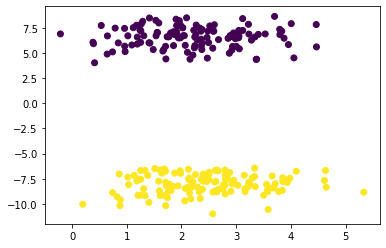

In [7]:
# plot X[0] vs X[1] and colour points according to the class, y
plt.scatter(X_blobs250[:,0], X_blobs250[:,1], c=y_blobs250)  

In order to find the best model for the dataset, i.e. weights `w` and bias `b`, we divide each dataset randomly into training set (70%), validation set (15%), and testing set (15%).

To do so, I imported a method `from sklearn.model_selection import train_test_split`. First of all, I separate 70% of the dataset for main training, `X_blobs250_train` and `y_blobs250_train`. Then, separate the rest of them in half so that 15% each for tuning, `X_blobs250_validation` and `y_blobs250_validation`, and for final performance evaluation, `X_blobs250_test` and `y_blobs250_test`, according to the total dataset.

In [8]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_blobs250_train, X_rest, y_blobs250_train, y_rest = train_test_split(X_blobs250, y_blobs250, test_size=0.3)
X_blobs250_validation, X_blobs250_test, y_blobs250_validation, y_blobs250_test = train_test_split(X_rest, y_rest, test_size=0.5)

Before training a model, I apply Z-Normalisation to the dataset to achieve better results. The idea of Z-Normalisation is finding the mean `X_mean` and the standard deviation `X_std` values **from the training dataset** `X` and applying the values to training, validation, and testing datasets separately as a Normal distribution. So each dataset is transformed by `(dataset - X_mean) / X_std`. Note that Z-Normalisation only applys to `X` but not to the target `y`.

### Brief Description of Algorithm (Z-Normalisation)
**ZNormalisation.*find***
* Calculate the mean `X_mean` and the standard deviation `X_std` from the input `X`
* Return `X_mean` and `X_std`

**ZNormalisation.*apply***
* Apply Z-normalisation with the input mean `X_mean` and the input standard deviation `X_std` to the input dataset `X`

In [9]:
class ZNormalisation:
    def find(self, X):
        X_mean = np.mean(X)
        X_std = np.std(X)
        return X_mean, X_std

    def apply(self, X, X_mean, X_std):
        return (X - X_mean) / X_std

In [10]:
# Z-normalisation for training and testing data
znormal = ZNormalisation()

# find mean and std from training data
X_blobs250_mean, X_blobs250_std = znormal.find(X_blobs250_train)

# apply normalisation by the mean and the std to training, validation and testing data
normalised_X_blobs250_train = znormal.apply(X_blobs250_train, X_blobs250_mean, X_blobs250_std)
normalised_X_blobs250_validation = znormal.apply(X_blobs250_validation, X_blobs250_mean, X_blobs250_std)
normalised_X_blobs250_test = znormal.apply(X_blobs250_test, X_blobs250_mean, X_blobs250_std)

We will use the training dataset and the validation dataset to find the best learning rate, `alpha`. The function `MyLogisticRegression.find_learning_rate` will train Logistic Regression model with the training dataset and a different `alpha` value and compare the accuracies of the models with the `alpha`s by validation dataset. The best `alpha` is then from the highest accuracy result (and the smaller number of iterations if there are many `alpha`s for the highest accuracy).

In [11]:
lr = MyLogisticRegression()

# find the best learning rate from training and validation
alpha_blobs250 = lr.find_learning_rate(normalised_X_blobs250_train, y_blobs250_train, normalised_X_blobs250_validation, y_blobs250_validation)
print("Blobs 250 LR alpha:", alpha_blobs250)

Blobs 250 LR alpha: 0.01


Now with the best alpha for the dataset, `alpha_blobs250`, we fit a logistic regression model to find weights `w` and bias `b`. 

The results of the cost function over iterations tends to 0 as shown in the graph. However, the graph can be noisy since we calculate a single case each iteration, aka Stochastic Gradient Descent. We will always get some that are high values, because these are the cases that are hard to classify, while the results should converge over time.

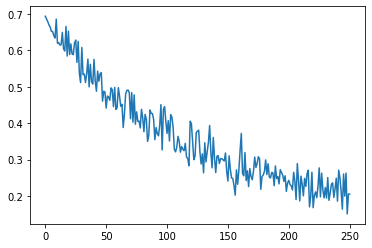

In [12]:
w_blobs250_train, b_blobs250_train, J_blobs250_interations = lr.fit(normalised_X_blobs250_train, y_blobs250_train, alpha_blobs250, return_cost=True)

# print a plot for cost by iterations
plt.plot(J_blobs250_interations)
plt.show()

The prediction results of the testing datasets with the weights `w_blobs250_train` and bias `b_blobs250_train` found by training dataset are shown below. 
As expected, the trained model found the straight line correctly to divide two classes, 0 and 1. Thus, we achieved 100% accurate results on the test set for *blobs250*.

In [13]:
# compare the predicted outputs and the actual data
y_blobs250_predict = lr.predict(normalised_X_blobs250_test , w_blobs250_train, b_blobs250_train)
print("LR y_blobs250_estimate\n", np.array(y_blobs250_predict))
print("LR y_blobs250_test\n", y_blobs250_test)

accuracy_blobs250 = accuracy(y_blobs250_test, y_blobs250_predict)
print("Blobs 250 LR Accuracy:", accuracy_blobs250)

LR y_blobs250_estimate
 [0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 1]
LR y_blobs250_test
 [0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 1]
Blobs 250 LR Accuracy: 100.0


Secondly, we will test Logistic Regression code with the dataset "moons400.csv". 

The *moons400* dataset has total of 400 training cases and 2 attributes, i.e. 'X0' and 'X1', in `X_moons400`. Also, the target `y_moons400` has total of 400 cases and 1 attribute, i.e. 'Class'.

In [14]:
df_moons400 = pd.read_csv("moons400.csv")

# The y values are those labelled 'Class': extract their values
y_moons400 = df_moons400['Class'].values

# The x values are all other columns
del df_moons400['Class']  # drop the 'Class' column from the dataframe
X_moons400 = df_moons400.values  # convert the remaining columns to a numpy array

# np.shape returns all dimensions of the array
(nsamples, nattribs) = np.shape(X_moons400)
print ("Moons 400 X: nsamples =", nsamples, ", nattribs =", nattribs)

# You can transpose the y data using 'reshape'
yt_moons400 = np.reshape(y_moons400, (len(y_moons400),1))  
(nsamples, nattribs) = np.shape(yt_moons400)
print ("Moons 400 y transpose: nsamples =", nsamples, ", nattribs =", nattribs)

Moons 400 X: nsamples = 400 , nattribs = 2
Moons 400 y transpose: nsamples = 400 , nattribs = 1


Unlike *blobs250*, the *moons400* dataset is not linearly separable as shown. Thus, it does not seem to have a straight dividing line to separate two classes perfectly.

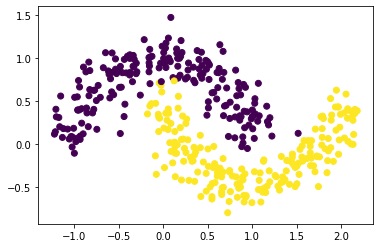

In [15]:
# plot X[0] vs X[1] and colour points according to the class, y
plt.scatter(X_moons400[:,0], X_moons400[:,1], c=y_moons400)  

Similarly to *blobs250*, we divide each dataset randomly into training set (70%), validation set (15%), and testing set (15%) to find the best model for the dataset, i.e. weights `w` and bias `b`.

Again, I separate 70% of the *moons400* dataset for main training, `X_moons400_train` and `y_moons400_train`. Then, separate the rest of them in half so that 15% each for tuning, `X_moons400_validation` and `y_moons400_validation`, and for final performance evaluation, `X_moons400_test` and `y_moons400_test`, according to the total dataset.

In [16]:
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_moons400_train, X_rest, y_moons400_train, y_rest = train_test_split(X_moons400, y_moons400, test_size=0.3)
X_moons400_validation, X_moons400_test, y_moons400_validation, y_moons400_test = train_test_split(X_rest, y_rest, test_size=0.5)

We will also apply Z-Normalisation to the dataset to achieve better results before training a model.

In [17]:
# find mean and std from training data
X_moons400_mean, X_moons400_std = znormal.find(X_moons400_train)

# apply normalisation by the mean and the std to training, validation and testing data
normalised_X_moons400_train = znormal.apply(X_moons400_train, X_moons400_mean, X_moons400_std)
normalised_X_moons400_validation = znormal.apply(X_moons400_validation, X_moons400_mean, X_moons400_std)
normalised_X_moons400_test = znormal.apply(X_moons400_test, X_moons400_mean, X_moons400_std)

Similarly to find the best learning rate, `alpha`, the training dataset and the validation dataset are used. 

In [18]:
# find the best learning rate from training and validation
alpha_moons400 = lr.find_learning_rate(normalised_X_moons400_train, y_moons400_train, normalised_X_moons400_validation, y_moons400_validation)
print("Moons 400 alpha:", alpha_moons400)

Moons 400 alpha: 0.1


Now with the best `alpha` found by training set and validation set, `alpha_moons400`, we fit a logistic regression model to find weights `w_moons400_train` and bias `b_moons400_train` with the training dataset. 

The results of the cost function over iterations tends to 0 as shown in the graph. However, the graph can be noisy since we calculate a single case each iteration, aka Stochastic Gradient Descent.

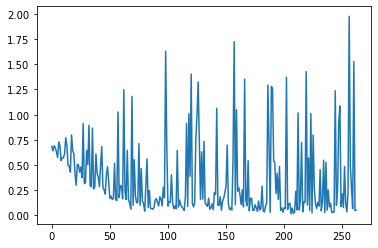

In [19]:
w_moons400_train, b_moons400_train, J_moons400_interations = lr.fit(normalised_X_moons400_train, y_moons400_train, alpha_moons400, return_cost=True)

# print a plot for cost by iterations
plt.plot(J_moons400_interations)
plt.show()

The prediction results of the normalised testing datasets `normalised_X_moons400_test` with the weights `w_moons400_train` and bias `b_moons400_train` found by training dataset are shown below. 

As expected, the trained model found the best possible straight line to divide two classes, 0 and 1, but we could NOT achieve 100% accurate results on the test set for *moons400*.

In [20]:
# compare the predicted outputs and the actual data
y_moons400_predict = lr.predict(normalised_X_moons400_test, w_moons400_train, b_moons400_train)
print("LR y_moons400_predict\n", np.array(y_moons400_predict))
print("LR y_moons400_test\n", y_moons400_test)

accuracy_moons400 = accuracy(y_moons400_test, y_moons400_predict)
print("Moons400 LR Accuracy:", accuracy_moons400)

LR y_moons400_predict
 [1 1 1 0 1 1 0 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 1 0 0 0
 1 1 1 1 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1]
LR y_moons400_test
 [1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0
 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1]
Moons400 LR Accuracy: 81.66666666666667


## Part 3: Implement and Test a Shallow Neural Network

To overcome the drawback of Logistic Regression that only finds a linear line for classification, e.g. *moons400* prediction, Neural Network algorithm is introduced. In here, I will implement 2-Layer Neural Network learned in lecture 3, aka Shallow Neural Network.

For the implementation of a Shallow Neural Network, I will re-use the *Sigmoid* function as an activation function. Therefore, we still need `sigmoid` and `stochastic_cost_function`. We will also need a derivative of the activation function `sigmoid_derivative` in hidden layers which is defined as follows.

        f'(z) = f(z) * (1 - f(z))

In [21]:
def sigmoid_derivative(z):
    sigmoid_z = sigmoid(z)
    return sigmoid_z * (1 - sigmoid_z)

At forward propagation stage, we define `zi_l` as sum of inputs into node *i* in layer *l*, and `ai_l` as the output (activation) of node *i* in layer *l* where `f_l()` is the activation function for layer *l*. As defined `a_L = y_hat`, the outputs from forward propagation are the predictions when a Neural Network is deployed into an applicaion.

        zi_l = sum_j (Wij_l * aj_l-1 + bi_l) (= Wi_l.dot(ai_l-1) + bi_l)
        ai_l = f_l(zi_l) = sigmoid(zi_l)
        ai_l0 = xi
        ai_L = yi_hat

At back propagation stage, we calculate the following gradients in an output layer and a hidden layer since there are only two layers in the implementation.
* Output layer (L=l2)
        
        delta_z1_L = a1_L - y1 = a1_l2 - y_random_one_train = delta_z1_l2
        delta_W1i_L = delta_z1_L * ai_L-1 
                        (= delta_z1_l2 * np.array(a_l1) = delta_W1i_l2)
        delta_b1_L = delta_z1_L = delta_b1_l2
        
* Hidden layer (l1)
    
        delta_zi_l = f'(zi_l) * sum_j (delta_zj_l+1 * Wji_l+1)
                    = f'(zi_l1) * sum_j (delta_zj_l2 * Wji_l2)
                        (= np.multiply(sigmoid_derivative(np.array(z_l1)), W_l2) * delta_z1_l2 = delta_zi_l1)
        delta_Wji_l = delta_z_l * ai_l-1
                    = delta_z_l1 * ai_l0
                        (= delta_zi_l1[i] * X_random_one_train = delta_Wji_l1) 
        delta_bj_l = delta_zj_l (= delta_zi_l1)

Finally, we update all weights and biases at Stochastic Gradient Descent stage.

        Wji_l -= alpha * delta_Wji_l
        bj_l -= alpha * delta_bj_l

### Brief Description of Algorithm (Shallow Neural Network)
**MyShallowNeuralNetwork.*fit***
* Set values for `threshold` and hyperparameters `node`, `alpha`, `epoch`
    * `node` for the number of nodes in the hidden layer
        * if `node` is not given, set `node` to the number of attributes in the input `X`
    * `alpha` for learning rate
    * `epoch` for the number of epochs for the max number of iterations

* Initialise `W` and `b` to a set of small random numbers
    * Set `W` and `b` to each layer, i.e. `W_l1`, `W_l2`, `b_l1` and `b1_l2`
    
* Loop until convergence or max number of iterations:
    * Select a single example `{X_random_one_train, y_random_one_train}` from training set at random (Stochastic Gradient Descent)
    * FORWARD PROPAGATION STAGE
        * Calculate output(s) for the training case, and the cost
            * Calculate `z_l1` and `a_l1` as shown above with `X_random_one_train`, `W_l1` and `b_l1`
            * Calculate `z1_l2` and `a1_l2` as shown above with `a_l1`, `W_l2` and `b1_l2`
        * Calculate `J_curr` by `stochastic_cost_function` with correct label `y_random_one_train` and prediction `a1_l2`
        * Check convergence by absolute value of `J_curr` being less than `threshold`

    * BACK PROPAGATION STAGE
        * Propagate the output errors back through the network
        * Numerically calculate the derivatives of `W` and `b` w.r.t. the cost
        * OUTPUT LAYER
            * Calculate `delta_z1_l2`, `delta_W1i_l2` and `delta_b1_l2` as shown above
            
        * HIDDEN LAYER
            * Calculate `delta_zi_l1`, `delta_bj_l1`, and `delta_Wji_l1` as shown above
        
    * STOCHASTIC GRADIENT DESCENT UPDATE STAGE
        * Adjust `W` and `b` values in a direction to reduce cost as given by derivatives, by an amount controlled by the learning rate
            * Update `W_l1`, `b_l1`, `W_l2` and `b1_l2` as shown above


**MyShallowNeuralNetwork.*predict***
* Apply weights `W_l1` and `W_l2` and biases `b_l1` and `b1_l2` to SNN with the input `X` and get `y_hat` by `sigmoid` function
* Make a prediction by checking whether the probability is greater than 0.5 that the actual output `y` is 1 given a set of input `X`.

**MyShallowNeuralNetwork.*find_best_index***
* Compare the accuracies on the list `accuracy_list` to find the indices of the highest accuracy
* If the highest accuracy occurs more than once, get the index of the smallest iteration taken in `iteration_list` among them

**MyShallowNeuralNetwork.*find_hyperparameters***
* Loop for each candidate `node` value - find the best `alpha` (& `epoch`) in each `node`:
    * Loop for each candidate `alpha` value - find the best `epoch` in each `alpha`: 
        * Loop for each candidate `epoch` value:
            * Fit the model
            * Predict the output
        * Find the best epoch index from `accuracy_for_epochs` and `iteration_for_epochs`
        
    * Find the best alpha index from `accuracy_for_alphas` and `iteration_for_alphas`

* Find the best node index from `accuracy_for_nodes` and `iteration_for_nodes`
* Get the best `node`, `alpha` and `epoch` from the best node index

In [22]:
class MyShallowNeuralNetwork:
    def fit(self, X, y, node=None, alpha=0.2, epoch=10, return_iteration=False, return_cost=False):
        # initialisation
        one_epoch = len(X)
        max_iterations = epoch * one_epoch
        # threshold - hard code for now
        threshold = 1 * math.exp(-8)
        # set small random values of W and b
        X_num_feature = X.shape[1]
        if node is None:
            node = X_num_feature
        W_l1 = np.random.normal(0, 0.01, size=(node, X_num_feature))  # small random value matrix in normal distribution for layer l=1
        W_l2 = np.random.normal(0, 0.01, size=(1, node))[0]  # small random values for layer l=L=2
        b_l1 = np.random.normal(0, 0.01, size=(1, node))[0]  # small random values for layer l=1
        b1_l2 = np.random.normal(0, 0.01, size=1)[0]  # small random values for layer l=L=2
        # Loop for max iterations
        converged = False
        iteration = 0
        J_epochs = []
        while not converged and iteration < max_iterations:
            # single example from training set selected at random (Stochastic Gradient Descent)
            # select a random row of X and y
            X_copy = X.copy()
            y_copy = y.copy()
            random_indice = np.random.choice(X_copy.shape[0], size=1, replace=False)
            X_random_one_train = X_copy[random_indice, :][0] # Xj
            y_random_one_train = y_copy[random_indice][0]

            # Forward Propagation step
                # * calculate output(s) for the training case, and the cost
            # update W, b, a in l-th layer
            # i-th node in layer l=1
            z_l1 = []
            a_l1 = []
            for i in range(node):
                Wi_l1 = W_l1[i]
                bi_l1 = b_l1[i]
                zi_l1 = X_random_one_train.dot(Wi_l1) + bi_l1
                z_l1.append(zi_l1)
                a_l1.append(sigmoid(zi_l1)) # activation function = Logistic = Sigmoid function
            # node 1 layer l=L=2
            z1_l2 = W_l2.dot(a_l1) + b1_l2
            a1_l2 = sigmoid(z1_l2) # y_hat: prediction
            J_curr = stochastic_cost_function(y_random_one_train, a1_l2)
            if iteration % one_epoch == 0: # every multiply of one_epoch size
                J_epochs.append(J_curr)
            if iteration > 1 and abs(J_curr) < threshold:
                converged = True

            # Back Propagation step
                # * propagate the output errors back through the network
                # * numerically calculate the derivatives of W and b w.r.t the cost
            # output layer
            delta_z1_l2 = a1_l2 - y_random_one_train
            delta_W1i_l2 = delta_z1_l2 * np.array(a_l1) # numpy multiply by scalar
            delta_b1_l2 = delta_z1_l2
            # hidden layer
            delta_zi_l1 = np.multiply(sigmoid_derivative(np.array(z_l1)), W_l2) * delta_z1_l2 # numpy element-wise multiply
            delta_bj_l1 = delta_zi_l1
            for i in range(node):
                delta_Wji_l1 = delta_zi_l1[i] * X_random_one_train
                # Stochastic Gradient Descent Update step - for next four lines
                    # * Adjust W and b values in a direction to reduce cost as given by derivatives, by an amount controlled by the learning rate
                W_l1[i] -= alpha * delta_Wji_l1
            b_l1 -= alpha * delta_bj_l1
            W_l2 -= alpha * delta_W1i_l2
            b1_l2 -= alpha * delta_b1_l2

            iteration += 1
        if return_iteration and return_cost:
            return W_l1, b_l1, W_l2, b1_l2, iteration, J_epochs
        elif return_iteration:
            return W_l1, b_l1, W_l2, b1_l2, iteration
        elif return_cost:
            return W_l1, b_l1, W_l2, b1_l2, J_epochs
        else:
            return W_l1, b_l1, W_l2, b1_l2

    def predict(self, X, W_l1, b_l1, W_l2, b1_l2):
        y_hat = []
        for Xj in X:
            # i-th node in layer l=1
            ai_l1 = []
            for i in range(W_l1.shape[0]): # the number of nodes in hidden layer
                Wi_l1 = W_l1[i]
                bi_l1 = b_l1[i]
                zi_l1 = Xj.dot(Wi_l1) + bi_l1  # numpy dot
                ai_l1.append(sigmoid(zi_l1))  # activation function = Logistic = Sigmoid function
            # node 1 layer l=L=2
            z1_l2 = W_l2.dot(ai_l1) + b1_l2
            yj_hat = sigmoid(z1_l2)  # a1_l2
            y_hat.append(yj_hat)
        y_predict = [(lambda i: 0 if i < 0.5 else 1)(i) for i in y_hat] # 0 if y_hat < 0.5 else 1
        return y_predict

    def find_best_index(self, accuracy_list, iteration_list):
        max_accuracy_indices = np.argwhere(accuracy_list == np.amax(accuracy_list))  # find index of max
        max_accuracy_indices = np.reshape(max_accuracy_indices, len(max_accuracy_indices))  # double list to flat list
        max_accuracy_indices = max_accuracy_indices.tolist()
        iteration_list = np.array(iteration_list)  # get elements by index list
        min_iteration_indices = np.argwhere(iteration_list == np.amin(list(np.array(iteration_list[max_accuracy_indices]))))
        return min_iteration_indices[0][0]

    def find_hyperparameters(self, X, y, X_validation, y_validation, nodes=[1, 2, 3, 4, 5], alphas=[0.01, 0.03, 0.05, 0.1, 0.3], epochs=[1, 5, 10, 100, 200]):
        accuracy_for_nodes = []
        iteration_for_nodes = []
        best_alpha_for_nodes = []
        best_epoch_for_nodes =[]
        for node in nodes:
            accuracy_for_alphas = []
            iteration_for_alphas = []
            best_epoch_for_alphas = []
            for alpha in alphas:
                accuracy_for_epochs = []
                iteration_for_epochs = []
                for epoch in epochs:
                    W_l1, b_l1, W_l2, b1_l2, iteration = self.fit(X, y, node, alpha, epoch, return_iteration=True)
                    y_predict = self.predict(X_validation, W_l1, b_l1, W_l2, b1_l2)
                    prediction_accuracy = accuracy(y_validation, y_predict)
                    accuracy_for_epochs.append(prediction_accuracy)
                    iteration_for_epochs.append(iteration)
                # find the best epoch for each alpha
                best_epoch_index = self.find_best_index(accuracy_for_epochs, iteration_for_epochs)

                accuracy_for_alphas.append(accuracy_for_epochs[best_epoch_index])
                iteration_for_alphas.append(iteration_for_epochs[best_epoch_index])
                best_epoch_for_alphas.append(epochs[best_epoch_index])
            # find the best alpha
            best_alpha_index = self.find_best_index(accuracy_for_alphas, iteration_for_alphas)

            accuracy_for_nodes.append(accuracy_for_alphas[best_alpha_index])
            iteration_for_nodes.append(iteration_for_alphas[best_alpha_index])
            best_alpha_for_nodes.append(alphas[best_alpha_index])
            best_epoch_for_nodes.append(best_epoch_for_alphas[best_alpha_index])
        # find the best node
        best_node_index = self.find_best_index(accuracy_for_nodes, iteration_for_nodes)
        return nodes[best_node_index], best_alpha_for_nodes[best_node_index], best_epoch_for_nodes[best_node_index]

Now we test `MyShallowNeuralNetwork` with *blobs250* datasets as in Part 2. Firstly, we find the best values for the hyperparameters `node`, `alpha` and `epoch` by the method `MyShallowNeuralNetwork.find_hyperparameters` with training dataset and validation dataset, i.e. `normalised_X_blobs250_train`, `y_blobs250_train`, `normalised_X_blobs250_validation` and `y_blobs250_validation`.

One thing that stands out to me is that the learning rate `snn_alpha_blobs250` is quite big! SGD tends to be very slow. Therefore, from the tuning phase, the higher learning rate `alpha` returns the better performance.

We then fit our Shallow Neural Network model with the training datasets and the best hyperparameters found.

In [23]:
snn = MyShallowNeuralNetwork()

snn_node_blob250, snn_alpha_blobs250, snn_epoch_blobs250 = snn.find_hyperparameters(normalised_X_blobs250_train, y_blobs250_train, normalised_X_blobs250_validation, y_blobs250_validation)
print("Blobs 250 SNN node:", snn_node_blob250)
print("Blobs 250 SNN alpha:", snn_alpha_blobs250)
print("Blobs 250 SNN # of epochs:", snn_epoch_blobs250)

W_l1_blobs250_train, b_l1_blobs250_train, W_l2_blobs250_train, b_l2_blobs250_train, J_blobs250_epochs = snn.fit(normalised_X_blobs250_train, y_blobs250_train, node=snn_node_blob250, alpha=snn_alpha_blobs250, epoch=snn_epoch_blobs250, return_cost=True)

if len(J_blobs250_epochs) > 1: # don't plot if no more than one element
    plt.plot(J_blobs250_epochs)
    plt.show()

Blobs 250 SNN node: 1
Blobs 250 SNN alpha: 0.3
Blobs 250 SNN # of epochs: 1


The prediction results of the testing datasets with the weights `W_l1_blobs250_train` and `W_l2_blobs250_train` and biases `b_l1_blobs250_train` and `b_l2_blobs250_train` found by training dataset are shown below. 

As expected, the trained model predicts two classes correctly. Thus, we achieved 100% accurate results on the test set with `MyShallowNeuralNetwork` for *blobs250*.

In [24]:
y_blobs250_predict = snn.predict(normalised_X_blobs250_test , W_l1_blobs250_train, b_l1_blobs250_train, W_l2_blobs250_train, b_l2_blobs250_train)
print("SNN y_blobs250_estimate\n", np.array(y_blobs250_predict))
print("SNN y_blobs250_test\n", y_blobs250_test)

accuracy_blobs250 = accuracy(y_blobs250_test, y_blobs250_predict)
print("Blobs 250 SNN Accuracy:", accuracy_blobs250)

SNN y_blobs250_estimate
 [0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 1]
SNN y_blobs250_test
 [0 0 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 1]
Blobs 250 SNN Accuracy: 100.0


Also, we test `MyShallowNeuralNetwork` with *moons400* datasets as in Part 2. Similarly, to find the best values for the hyperparameters `node`, `alpha` and `epoch` by the method `MyShallowNeuralNetwork.find_hyperparameters` with training dataset and validation dataset, i.e. `normalised_X_moons400_train`, `y_moons400_train`, `normalised_X_moons400_validation` and `y_moons400_validation`.

Again, the learning rate `snn_alpha_moons400` is quite big! So I can expect that SGD tends to be very slow and the higher learning rate `alpha` returns the better performance during tuning.

We then fit our Shallow Neural Network model with the training datasets and the best hyperparameters found.

The results of the cost function over the number of epochs are taken at the end of every epoch (not averaged out!). Therefore, the graph can be noisy since we calculate a single case each iteration, aka Stochastic Gradient Descent. We will always get some that are high values, because these are the cases that are hard to classify, while the results should converge to 0 over time.

Moons 400 SNN node: 4
Moons 400 SNN alpha: 0.3
Moons 400 SNN # of epochs: 100


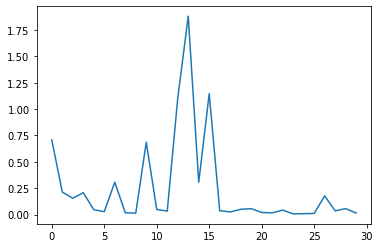

In [25]:
snn_node_moons400, snn_alpha_moons400, snn_epoch_moons400 = snn.find_hyperparameters(normalised_X_moons400_train, y_moons400_train, normalised_X_moons400_validation, y_moons400_validation)
print("Moons 400 SNN node:", snn_node_moons400)
print("Moons 400 SNN alpha:", snn_alpha_moons400)
print("Moons 400 SNN # of epochs:", snn_epoch_moons400)

W_l1_moons400_train, b_l1_moons400_train, W_l2_moons400_train, b_l2_moons400_train, J_moons400_epochs = snn.fit(normalised_X_moons400_train, y_moons400_train, node=snn_node_moons400, alpha=snn_alpha_moons400, epoch=snn_epoch_moons400, return_cost=True)

plt.plot(J_moons400_epochs)
plt.show()

The prediction results of the normalised testing datasets `normalised_X_moons400_test` with the weights `W_l1_moons400_train` and `W_l2_moons400_train` and biases `b_l1_moons400_train` and `b_l2_moons400_train` found by training dataset are shown below. 

The trained model by `MyShallowNeuralNetwork` predicts two classes close to 100% now on the test set for *moons400*. Thus, Shallow Neural Network can perform better at non-linearly separable datasets than Logistic Regression.

In [26]:
y_moons400_predict = snn.predict(normalised_X_moons400_test, W_l1_moons400_train, b_l1_moons400_train, W_l2_moons400_train, b_l2_moons400_train)
print("Moons 400 SNN y_moons400_predict\n", np.array(y_moons400_predict))
print("Moons 400 SNN y_moons400_test\n", y_moons400_test)

accuracy_moons400 = accuracy(y_moons400_test, y_moons400_predict)
print("Moons 400 SNN Accuracy:", accuracy_moons400)

Moons 400 SNN y_moons400_predict
 [1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1
 1 1 1 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 0 0 1 0 1]
Moons 400 SNN y_moons400_test
 [1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 0 0
 1 1 1 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1]
Moons 400 SNN Accuracy: 96.66666666666667


## Part 4: Challenging Task

In this part, my task is to distinguish between two classes '**truck**' and '**automobile**' from the CIFAR-10 dataset: https://www.cs.toronto.edu/~kriz/cifar.html

In [27]:
# This function taken from the CIFAR website
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [28]:
def loadbatch(batchname):
    folder = 'cifar-10-batches-py'
    batch = unpickle(folder+"/"+batchname)
    return batch

def loadlabelnames():
    folder = 'cifar-10-batches-py'
    meta = unpickle(folder+"/"+'batches.meta')
    return meta[b'label_names']

The images have 3 colour channels (RGB). In this assignment, I convert the images to greyscale to have one channel, i.e. vector of 1024 floats. The main idea of the greyscale is to apply weights of \[0.2989, 0.5870, 0.1140\] to 3 colour channels (ref: https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python).

Also, we know the range of the pixel is between 0 and 255. Therefore, we **normalise** the picture array dividing by 255 to have the pixel range between 0 and 1. As a result, we add a parameter `vmax=1` to the function `matplotlib.pyplot.imshow` to visualise the image.

In [29]:
def greyscale(data, index):
    picture = data[index]
    picture.shape = (3, 32, 32)
    # Plot.imshow requires the RGB to be the third dimension, not the first, so need to rearrange
    picture = picture.transpose([1, 2, 0])
    grey_picture = np.dot(picture[..., :3], [0.2989, 0.5870, 0.1140])  # greyscale
    # Normalisation - Pixel 0 to 255 normalised by dividing by 255
    normalised_grey_picture = np.array(grey_picture) / 255
    return normalised_grey_picture

def visualise(picture):
    plt.imshow(picture, vmax=1)
    plt.show()

The entire CIFAR-10 datasets are too big to handle by a single laptop - time consuming - so I will select random subsets with 'data_batch_5'.

In [30]:
batch = loadbatch('data_batch_5')
print("Number of items in the batch is", len(batch))

# Display all keys, so we can see the ones we want
print('All keys in the batch:', batch.keys())

Number of items in the batch is 4
All keys in the batch: dict_keys([b'batch_label', b'labels', b'data', b'filenames'])


In [31]:
data = batch[b'data']
labels = batch[b'labels']
print ("size of data in this batch:", len(data), ", size of labels:", len(labels))
print (type(data))
print(data.shape)

names = loadlabelnames()

size of data in this batch: 10000 , size of labels: 10000
<class 'numpy.ndarray'>
(10000, 3072)


As my task is to distinguish between two classes 'truck' and 'automobile' only, I select datasets that are either 'truck' or 'automobile'. The selected datasets are then reshaped into 1D numpy array to apply to Neural Network `MyShallowNeuralNetwork`. The reshaped numpy arrays are then saved into `X_cifar10`. Also, save **'truck' to 0** and **'automobile' to 1** to `y_cifar10` for classification.

In [32]:
# Get two classes: truck for 0, automobile for 1
X_cifar10 = []
y_cifar10 = []
grey_pictures = []
for i in range(len(labels)):
    if names[labels[i]] == b'truck': # truck is 0
        grey_picture = greyscale(data, i)
        grey_pictures.append(grey_picture)
        X_cifar10.append(grey_picture.reshape(1, 1024)[0])
        y_cifar10.append(0)
    elif names[labels[i]] == b'automobile': # automobile is 1
        grey_picture = greyscale(data, i)
        grey_pictures.append(grey_picture)
        X_cifar10.append(grey_picture.reshape(1, 1024)[0])
        y_cifar10.append(1)
X_cifar10 = np.array(X_cifar10)
y_cifar10 = np.array(y_cifar10)

Therefore, the filtered images (datasets) are only 'truck' or 'automobile'. The first 10 images are visualised below.

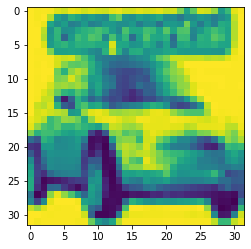

Image 0 : Class is 'automobile'.


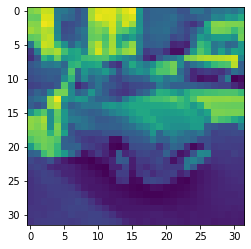

Image 1 : Class is 'automobile'.


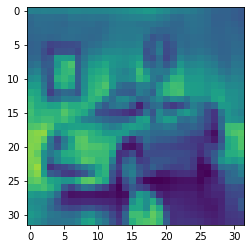

Image 2 : Class is 'automobile'.


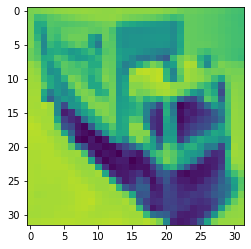

Image 3 : Class is 'truck'.


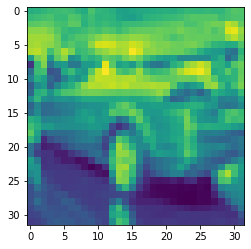

Image 4 : Class is 'automobile'.


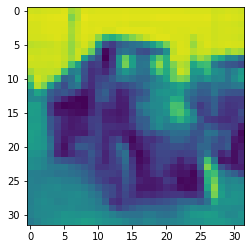

Image 5 : Class is 'truck'.


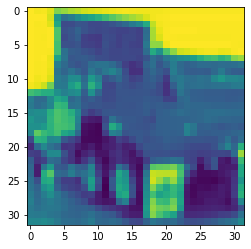

Image 6 : Class is 'truck'.


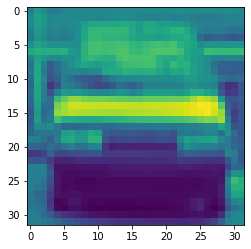

Image 7 : Class is 'automobile'.


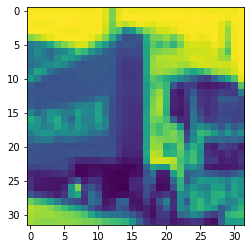

Image 8 : Class is 'truck'.


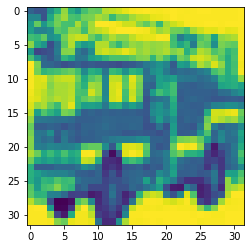

Image 9 : Class is 'truck'.


In [33]:
for i in range(10):
    visualise(grey_pictures[i])
    if y_cifar10[i] == 0:
        print("Image", i,": Class is 'truck'.")
    else:
        print("Image", i,": Class is 'automobile'.")

After filtering two classes in the batch, the total number of instances in `X_cifar10` becomes 2036 where the length of each image vector is 1024.

In [34]:
print("X_cifar10 shape after filtering two classes of 'truck' and 'automobile':", X_cifar10.shape)

X_cifar10 shape after filtering two classes of 'truck' and 'automobile': (2036, 1024)


Similar to Part 2, the datasets are randomly divided into training set (70%), validation set (15%), and testing set (15%) to find the best model for the dataset.

So I separate 70% of the *cifar10* dataset for main training, `X_cifar10_train` and `y_cifar10_train`. Then, separate the rest of them in half so that 15% each for tuning, `X_cifar10_validation` and `y_cifar10_validation`, and for final performance evaluation, `X_cifar10_test` and `y_cifar10_test`, according to the total dataset.

Also, to find the best hyperparameters I set the node list to \[1, 10, 1024\] as mentioned in lecture 4 that one input node for each of pixels in Neural Network. Note that the length of each image vector is 1024 in this task.

The results of the cost function over the number of epochs `J_epochs` are taken at the end of every epoch (not averaged out!). Therefore, the graph looks noisy since we calculate a single case each iteration, aka Stochastic Gradient Descent.We will always get some that are high values, because these are the cases that are hard to classify, while the results should converge to 0 over time.

CIFAR 10 SNN node: 10
CIFAR 10 SNN alpha: 0.05
CIFAR 10 SNN epoch: 100


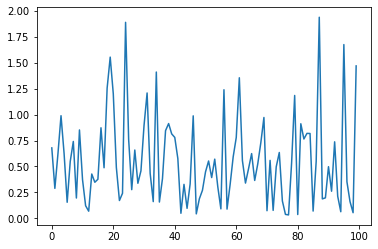

In [35]:
# 70% training, 15% validation, 15% testing
X_cifar10_train, X_rest, y_cifar10_train, y_rest = train_test_split(X_cifar10, y_cifar10, test_size=0.3)
X_cifar10_validation, X_cifar10_test, y_cifar10_validation, y_cifar10_test = train_test_split(X_rest, y_rest, test_size=0.5)


snn_node_cifar10, snn_alpha_cifar10, snn_epoch_cifar10 = snn.find_hyperparameters(X_cifar10_train, y_cifar10_train, X_cifar10_validation, y_cifar10_validation, nodes=[1, 10, 1024], alphas=[0.01, 0.05, 0.1, 0.2, 0.3], epochs=[10, 100, 200])
print("CIFAR 10 SNN node:", snn_node_cifar10)
print("CIFAR 10 SNN alpha:", snn_alpha_cifar10)
print("CIFAR 10 SNN epoch:", snn_epoch_cifar10)

W_l1_train, b_l1_train, W_l2_train, b_l2_train, J_epochs = snn.fit(X_cifar10_train, y_cifar10_train, node=snn_node_cifar10, alpha=snn_alpha_cifar10, epoch=snn_epoch_cifar10, return_cost=True)
plt.plot(J_epochs)
plt.show()

The prediction results of the normalised testing datasets `X_cifar10_test` with the weights `W_l1_train` and `W_l2_train` and biases `b_l1_train` and `b_l2_train` found by training dataset are shown below. 

The trained model by `MyShallowNeuralNetwork` predicts two classes better than 50% but not too close to 100% on the test set for *cifar10*. To improve the performance of Neural Network, more training data or more complex hidden layers or Batch/Mini-Batch Gradient Descent can help.

In [36]:
y_cifar10_predict = snn.predict(X_cifar10_test, W_l1_train, b_l1_train, W_l2_train, b_l2_train)
print("CIFAR 10 SNN y_cifar10_predict\n", np.array(y_cifar10_predict))
print("CIFAR 10 SNN y_cifar10_test\n", y_cifar10_test)

accuracy_cifar10 = accuracy(y_cifar10_test, y_cifar10_predict)
print("CIFAR 10 SNN Accuracy:", accuracy_cifar10)

CIFAR 10 SNN y_cifar10_predict
 [0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0
 0 1 1 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1
 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1
 0 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0
 1 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 1 0 0
 0 1 1 0 0 1 1 1 0 0]
CIFAR 10 SNN y_cifar10_test
 [1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1
 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0
 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1
 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0
 0 1 1 1 0 0 1 1 

## Part 5: Deep Learning Enhancements

To enhance my Shallow Neural Network `MyShallowNeuralNetwork`,  I will implement a training algorithm called Adaptive Moment Estimation (Adam Optimisation) that is combining the ideas from Momentum and RMSprop - from lecture 5. So Adam optimisation includes both velocity and acceleration terms. As a result, Adam optimisation will mainly modify Backprop and Gradient Descent update stages from `MyShallowNeuralNetwork`.

At back propagation stage, update all `V` and `S` terms.

        V_deltaW = (1 - beta1) * deltaW + beta1 * V_deltaW
        S_deltaW = (1 - beta2) * deltaW^2 + beta2 * S_deltaW
        VC_deltaW = V_deltaW / (1 - beta1^iteration)
        SC_deltaW = S_deltaW / (1 - beta2^iteration)
        
        V_deltab = (1 - beta1) * deltab + beta1 * V_deltab
        S_deltab = (1 - beta2) * deltab^2 + beta2 * S_deltab
        VC_deltab = V_deltab / (1 - beta1^iteration)
        SC_deltab = S_deltab / (1 - beta2^iteration)

At Gradient Descent update stage, we update weights `Wji_l` and bias `bj_l` at layer *l*.

        Wji_l -= alpha * VC_deltaWji_l / (sqrt(SC_deltaWji_l) + epsilon)
        bj_l =-= alpha * VC_deltabj_l / (sqrt(SC_deltabj_l) + epsilon)

### Brief Description of Algorithm (Shallow Neural Network with Adam Optimisation)
**MyAdamNeuralNetwork.*remove_nested_array***
* Check array dimension and reshape the array to convert nested array to flat array

**MyAdamNeuralNetwork.*fit*** (updates are in **bold** from `MyShallowNeuralNetwork`)
* Set values for `threshold` and hyperparameters `node`, `alpha`, `epoch`
    * `node` for the number of nodes in the hidden layer
        * if `node` is not given, set `node` to the number of attributes in the input `X`
    * `alpha` for learning rate
    * `epoch` for the number of epochs for the max number of iterations

* Initialise `W` and `b` to a set of small random numbers
    * Set `W` and `b` to each layer, i.e. `W_l1`, `W_l2`, `b_l1` and `b1_l2`

* **Initialise `V_deltaW_l1`, `V_deltaW_l2`, `V_deltab_l1`, `V_deltab_l2`, `S_deltaW_l1`, `S_deltaW_l2`, `S_deltab_l1`, `S_deltab_l2` to 0s**  

* **Initialise `beta1`=0.9 for 'velocity', `beta2`=0.999 for 'acceleration', `epsilon`=e^-8**

* Loop until convergence or max number of iterations:
    * Select a single example `{X_random_one_train, y_random_one_train}` from training set at random (Stochastic G.D.)
    * FORWARD PROPAGATION STAGE
        * Calculate output(s) for the training case, and the cost
            * Calculate `z_l1` and `a_l1` as shown above with `X_random_one_train`, `W_l1` and `b_l1`
            * Calculate `z1_l2` and `a1_l2` as shown above with `a_l1`, `W_l2` and `b1_l2`
        * Calculate `J_curr` by `stochastic_cost_function` with correct label `y_random_one_train` and prediction `a1_l2`
        * Check convergence by absolute value of `J_curr` being less than `threshold`

    * BACK PROPAGATION STAGE
        * Propagate the output errors back through the network
        * Numerically calculate the derivatives of `W` and `b` w.r.t. the cost
        * OUTPUT LAYER
            * Calculate `delta_z1_l2`, `delta_W1i_l2` and `delta_b1_l2` as shown above
            * **Calculate `V_deltaW_l2`, `S_deltaW_l2`, `VC_deltaW_l2`, `SC_deltaW_l2`, `V_deltab_l2`, `S_deltab_l2`, `VC_deltab_l2`, and `SC_deltab_l2` as shown above**
            
        * HIDDEN LAYER
            * Calculate `delta_zi_l1`, `delta_bj_l1`, and `delta_Wji_l1` as shown above
            * **Calculate `V_deltab_l1`, `S_deltab_l1`, `VC_deltab_l1`, `SC_deltab_l1`, `V_deltaW_l1`, `S_deltaW_l1`, `VC_deltaWi_l1`, and `SC_deltaWi_l1` as shown above**
        
    * STOCHASTIC GRADIENT DESCENT UPDATE STAGE
        * Adjust `W` and `b` values in a direction to reduce cost as given by derivatives, by an amount controlled by the learning rate
            * Update `W_l1`, `b_l1`, `W_l2` and `b1_l2` as shown above **with `VC_deltaWi_l1`, `SC_deltaWi_l1`, `VC_deltab_l1`, `SC_deltab_l1`, `VC_deltaW_l2`, `SC_deltaW_l2`, `VC_deltab_l2`, `SC_deltab_l2`, and `epsilon`**


**MyAdamNeuralNetwork.*predict***
* Same as `MyShallowNeuralNetwork.predict`

**MyAdamNeuralNetwork.*find_best_index***
* Same as `MyShallowNeuralNetwork.find_best_index`

**MyAdamNeuralNetwork.*find_hyperparameters***
* Same as `MyShallowNeuralNetwork.find_hyperparameters`


In [37]:
class MyAdamNeuralNetwork:
    def remove_nested_array(self, array):
        if array.ndim > 1:
            return np.reshape(array, array.shape[1])
        else:
            return np.reshape(array, array.shape[0])

    def fit(self, X, y, node=None, alpha=0.2, epoch=10, return_iteration=False, return_cost=False):
        # initialisation
        one_epoch = len(X)
        max_iterations = epoch * one_epoch
        # threshold - hard code for now
        threshold = 1 * math.exp(-8)
        # set small random values of W and b
        X_num_feature = X.shape[1]
        if node is None:
            node = X_num_feature
        W_l1 = np.random.normal(0, 0.01, size=(node, X_num_feature))  # small random value matrix in normal distribution for layer l=1
        W_l2 = np.random.normal(0, 0.01, size=(1, node))[0]  # small random values for layer l=L=2
        b_l1 = np.random.normal(0, 0.01, size=(1, node))[0]  # small random values for layer l=1
        b1_l2 = np.random.normal(0, 0.01, size=1)[0]  # small random values for layer l=L=2
        # Adam Optimisation Algorithm
            # * At start: for each weight W and bias b, initialise all V and S terms to 0
        V_deltaW_l1 = np.zeros((node, X_num_feature))
        V_deltaW_l2 = np.zeros((1, node))
        V_deltab_l1 = np.zeros((1, node))
        V_deltab_l2 = 0
        S_deltaW_l1 = np.zeros((node, X_num_feature))
        S_deltaW_l2 = np.zeros((1, node))
        S_deltab_l1 = np.zeros((1, node))
        S_deltab_l2 = 0
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1 * math.exp(-8)
        # Loop for max iterations
        converged = False
        iteration = 0
        J_epochs = []
        while not converged and iteration < max_iterations:
            # single example from training set selected at random (Stochastic Gradient Descent)
            # select a random row of X and y
            X_copy = X.copy()
            y_copy = y.copy()
            random_indice = np.random.choice(X_copy.shape[0], size=1, replace=False)
            X_random_one_train = X_copy[random_indice, :][0]  # Xj
            y_random_one_train = y_copy[random_indice][0]

            # Forward Propagation step
                # * calculate output(s) for the training case, and the cost
            # update W, b, a in l-th layer
            # i-th node in layer l=1
            z_l1 = []
            a_l1 = []
            for i in range(node):
                Wi_l1 = W_l1[i]
                bi_l1 = b_l1[i]
                zi_l1 = X_random_one_train.dot(Wi_l1) + bi_l1
                z_l1.append(zi_l1)
                a_l1.append(sigmoid(zi_l1))  # activation function = Logistic = Sigmoid function
            # node 1 layer l=L=2
            z1_l2 = W_l2.dot(a_l1) + b1_l2
            a1_l2 = sigmoid(z1_l2)  # y_hat: prediction
            J_curr = stochastic_cost_function(y_random_one_train, a1_l2)
            if iteration % one_epoch == 0:  # every multiply of one_epoch size
                J_epochs.append(J_curr)
            if iteration > 1 and abs(J_curr) < threshold:
                converged = True

            # Back Propagation step - Adam Optimisation Algorithm
            iteration += 1 # update iteration here to make the first iteration = 1 not 0
            delta_z1_l2 = a1_l2 - y_random_one_train
            delta_W1i_l2 = delta_z1_l2 * np.array(a_l1)  # numpy multiply by scalar
            # Adam
            V_deltaW_l2 = (1 - beta1) * delta_W1i_l2 + beta1 * V_deltaW_l2
            V_deltaW_l2 = self.remove_nested_array(V_deltaW_l2)
            S_deltaW_l2 = (1 - beta2) * np.power(delta_W1i_l2, 2) + beta2 * S_deltaW_l2 # numpy element-wise power
            S_deltaW_l2 = self.remove_nested_array(S_deltaW_l2)
            VC_deltaW_l2 =  V_deltaW_l2 / (1 - beta1 ** iteration) # numpy divide
            SC_deltaW_l2 = S_deltaW_l2 / (1 - beta2 ** iteration)

            delta_b1_l2 = delta_z1_l2
            # Adam
            V_deltab_l2 = (1 - beta1) * delta_b1_l2 + beta1 * V_deltab_l2
            S_deltab_l2 = (1 - beta2) * np.power(delta_b1_l2, 2) + beta2 * S_deltab_l2 # numpy element-wise power
            VC_deltab_l2 = V_deltab_l2 / (1 - beta1 ** iteration)
            SC_deltab_l2 = S_deltab_l2 / (1 - beta2 ** iteration)

            # hidden layer
            delta_zi_l1 = np.multiply(sigmoid_derivative(np.array(z_l1)), W_l2) * delta_z1_l2  # numpy element-wise multiply
            delta_bj_l1 = delta_zi_l1
            # Adam - similar to the layer 2
            V_deltab_l1 = (1 - beta1) * delta_bj_l1 + beta1 * V_deltab_l1
            V_deltab_l1 = self.remove_nested_array(V_deltab_l1)
            S_deltab_l1 = (1 - beta2) * np.power(delta_bj_l1, 2) + beta2 * S_deltab_l1
            S_deltab_l1 = self.remove_nested_array(S_deltab_l1)
            VC_deltab_l1 = V_deltab_l1 / (1 - beta1 ** iteration)
            SC_deltab_l1 = S_deltab_l1 / (1 - beta2 ** iteration)

            for i in range(node):
                delta_Wji_l1 = delta_zi_l1[i] * X_random_one_train
                # Adam
                V_deltaW_l1[i] = (1 - beta1) * delta_Wji_l1 + beta1 * V_deltaW_l1[i]
                S_deltaW_l1[i] = (1 - beta2) * np.power(delta_Wji_l1, 2) + beta2 * S_deltaW_l1[i]
                VC_deltaWi_l1 = V_deltaW_l1[i] / (1 - beta1 ** iteration)
                SC_deltaWi_l1 = S_deltaW_l1[i] / (1 - beta2 ** iteration)
                
                # Stochastic Gradient Descent Update step - Adam Optimisation - for next four lines
                W_l1[i] -= alpha * VC_deltaWi_l1 / (np.sqrt(SC_deltaWi_l1) + epsilon) # numpy element-wise sqrt
            b_l1 -= alpha * VC_deltab_l1 / (np.sqrt(SC_deltab_l1) + epsilon)
            W_l2 -= alpha * VC_deltaW_l2 / (np.sqrt(SC_deltaW_l2) + epsilon)
            b1_l2 -= alpha * VC_deltab_l2 / (np.sqrt(SC_deltab_l2) + epsilon)

        if return_iteration and return_cost:
            return W_l1, b_l1, W_l2, b1_l2, iteration, J_epochs
        elif return_iteration:
            return W_l1, b_l1, W_l2, b1_l2, iteration
        elif return_cost:
            return W_l1, b_l1, W_l2, b1_l2, J_epochs
        else:
            return W_l1, b_l1, W_l2, b1_l2

    def predict(self, X, W_l1, b_l1, W_l2, b1_l2):
        y_hat = []
        for Xj in X:
            # i-th node in layer l=1
            ai_l1 = []
            for i in range(W_l1.shape[0]):  # the number of nodes in hidden layer
                Wi_l1 = W_l1[i]
                bi_l1 = b_l1[i]
                zi_l1 = Xj.dot(Wi_l1) + bi_l1  # numpy dot
                ai_l1.append(sigmoid(zi_l1))  # activation function = Logistic = Sigmoid function
            # node 1 layer l=L=2
            z1_l2 = W_l2.dot(ai_l1) + b1_l2
            yj_hat = sigmoid(z1_l2)  # a1_l2
            y_hat.append(yj_hat)
        y_predict = [(lambda i: 0 if i < 0.5 else 1)(i) for i in y_hat]  # 0 if y_hat < 0.5 else 1
        return y_predict

    def find_best_index(self, accuracy_list, iteration_list):
        max_accuracy_indices = np.argwhere(accuracy_list == np.amax(accuracy_list))  # find index of max
        max_accuracy_indices = np.reshape(max_accuracy_indices, len(max_accuracy_indices))  # double list to flat list
        max_accuracy_indices = max_accuracy_indices.tolist()  # numpy to list
        iteration_list = np.array(iteration_list)  # get elements by index list
        min_iteration_indices = np.argwhere(iteration_list == np.amin(list(np.array(iteration_list[max_accuracy_indices]))))  # get elements by index list
        return min_iteration_indices[0][0]

    def find_hyperparameters(self, X, y, X_validation, y_validation, nodes=[1, 2, 3, 4, 5], alphas=[0.0005, 0.001, 0.003, 0.005, 0.01, 0.03, 0.05, 0.1], epochs=[1, 5, 10, 50, 100, 200]):
        accuracy_for_nodes = []
        iteration_for_nodes = []
        best_alpha_for_nodes = []
        best_epoch_for_nodes = []
        for node in nodes:
            accuracy_for_alphas = []
            iteration_for_alphas = []
            best_epoch_for_alphas = []
            for alpha in alphas:
                accuracy_for_epochs = []
                iteration_for_epochs = []
                for epoch in epochs:
                    W_l1, b_l1, W_l2, b1_l2, iteration = self.fit(X, y, node, alpha, epoch, return_iteration=True)
                    y_predict = self.predict(X_validation, W_l1, b_l1, W_l2, b1_l2)
                    prediction_accuracy = accuracy(y_validation, y_predict)
                    accuracy_for_epochs.append(prediction_accuracy)
                    iteration_for_epochs.append(iteration)
                # find the best epoch for each alpha
                best_epoch_index = self.find_best_index(accuracy_for_epochs, iteration_for_epochs)

                accuracy_for_alphas.append(accuracy_for_epochs[best_epoch_index])
                iteration_for_alphas.append(iteration_for_epochs[best_epoch_index])
                best_epoch_for_alphas.append(epochs[best_epoch_index])
            # find the best alpha
            best_alpha_index = self.find_best_index(accuracy_for_alphas, iteration_for_alphas)

            accuracy_for_nodes.append(accuracy_for_alphas[best_alpha_index])
            iteration_for_nodes.append(iteration_for_alphas[best_alpha_index])
            best_alpha_for_nodes.append(alphas[best_alpha_index])
            best_epoch_for_nodes.append(best_epoch_for_alphas[best_alpha_index])
        # find the best node
        best_node_index = self.find_best_index(accuracy_for_nodes, iteration_for_nodes)
        return nodes[best_node_index], best_alpha_for_nodes[best_node_index], best_epoch_for_nodes[best_node_index]

Similar to Part 4, we find the best hyperparameters by `MyAdamNeuralNetwork.find_hyperparameters`. Again, I set the node list to \[1, 10, 1024\] as mentioned in lecture 4 that one input node for each of pixels in Neural Network. Also, this Shallow Neural Network with Adam optimisation `MyAdamNeuralNetwork` tends to peform better at low learning rates, `alpha`. Therefore, I set the alpha list to \[0.0005, 0.001, 0.002\] in this task.

Again, the results of the cost function over the number of epochs `J_epochs` are taken at the end of every epoch (not averaged out!). Therefore, the graph looks noisy since we calculate a single case each iteration, aka Stochastic Gradient Descent. We will always get some that are high values, because these are the cases that are hard to classify, while the results should converge to 0 over time.

CIFAR 10 Adam NN node: 10
CIFAR 10 Adam NN alpha: 0.001
CIFAR 10 Adam NN epoch: 200


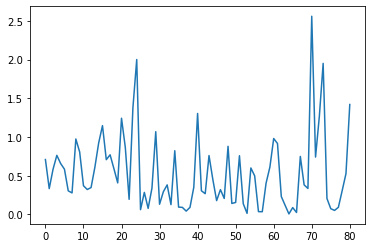

In [38]:
ann = MyAdamNeuralNetwork()

ann_node_cifar10, ann_alpha_cifar10, ann_epoch_cifar10 = ann.find_hyperparameters(X_cifar10_train, y_cifar10_train, X_cifar10_validation, y_cifar10_validation, nodes=[1, 10, 1024], alphas=[0.0005, 0.001, 0.002], epochs=[10, 100, 200])
print("CIFAR 10 Adam NN node:", ann_node_cifar10)
print("CIFAR 10 Adam NN alpha:", ann_alpha_cifar10)
print("CIFAR 10 Adam NN epoch:", ann_epoch_cifar10)

W_l1_train, b_l1_train, W_l2_train, b_l2_train, J_epochs = ann.fit(X_cifar10_train, y_cifar10_train, node=ann_node_cifar10, alpha=ann_alpha_cifar10, epoch=ann_epoch_cifar10, return_cost=True)

if len(J_epochs) > 1:
    plt.plot(J_epochs)
    plt.show()

The prediction results of the normalised testing datasets `X_cifar10_test` with the weights `W_l1_train` and `W_l2_train` and biases `b_l1_train` and `b_l2_train` found by `MyAdamNeuralNetwork` with training dataset are shown below. 

The trained model by `MyAdamNeuralNetwork` predicts two classes similar to `MyShallowNeuralNetwork` but it is still not too close to 100% on the test set for *cifar10*. To improve the performance of Neural Network, `accuracy_cifar10`, more training data or more complex hidden layers or Batch/Mini-Batch Gradient Descent can help.

In the meantime, `MyAdamNeuralNetwork` improved the speed of the performance, i.e. faster learning overall. For example, modeling a Neural Network with *cifar10* datasets took about 100 epochs in `MyShallowNeuralNetwork` but about 80 epochs in `MyAdamNeuralNetwork` from the training graphs. Also as mentioned earlier, `MyAdamNeuralNetwork` can perform at lower learning rate `alpha` but the performance can be still better than `MyShallowNeuralNetwork`. This is because Adam optimisation is able to change at a rate appropriate to itself, rather than one fixed learning rate. In other words, the previous changes in parameter values should influence the current direction of updates like Backprop with Momentum. 

In [39]:
y_cifar10_predict = ann.predict(X_cifar10_test, W_l1_train, b_l1_train, W_l2_train, b_l2_train)
print("CIFAR 10 Adam NN y_cifar10_predict\n", np.array(y_cifar10_predict))
print("CIFAR 10 Adam NN y_cifar10_test\n", y_cifar10_test)

accuracy_cifar10 = accuracy(y_cifar10_test, y_cifar10_predict)
print("CIFAR 10 Adam NN Accuracy:", accuracy_cifar10)

CIFAR 10 Adam NN y_cifar10_predict
 [1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 1 0
 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1
 0 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0
 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 0 0 0 1 1 0 1 1 0
 0 0 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 0
 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1
 0 1 0 1 0 1 1 1 0 0]
CIFAR 10 Adam NN y_cifar10_test
 [1 1 0 1 0 1 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1
 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0
 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0 0 0 1 1
 0 0 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0
 0 1 1 1 